### Effect on wages from changing age composition of workers

Brian Dew, @bd_econ

May 11, 2018

----

Calculate how the age of full-time workers has changed since 1994 using data from the basic monthly Current Population Survey.

In [37]:
# Import packages
import pandas as pd
import numpy as np
import wquantiles
import glob, os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

#path = '/home/domestic-ra/Dropbox (CEPR)/homestata/Brian/SP02-College_Returns/data/'
path = 'C:\Working\econ_data\micro\data'

In [38]:
files = glob.glob(os.path.join(path, "*.ft"))

df = pd.concat((pd.read_feather(f, nthreads=3) for f in files))

df1 = df[df['PRTAGE'].between(19,21)]
df = df[df['PRTAGE'].between(22,24)]

df1['y'] = np.where((df1['PEMLR'].isin([1, 2])) & (df1['PRFTLF'] == 1), 1, 0)
df1['p'] = np.where((df1['PEMLR'].isin([1, 2])) & (df1['PRFTLF'] == 2), 1, 0)
df1['n'] = np.where((df1['PRWNTJOB']==2) & (df1['PENLFACT']==3), 1, 0)
df1['u'] = np.where(df1['PREMPNOT']==2, 1, 0)
df1['o'] = np.where((df1['y']==0) & (df1['n']==0) & (df1['u']==0) & (df1['PEMLR']>4), 1, 0)

df['y'] = np.where((df['PEMLR'].isin([1, 2])) & (df['PRFTLF'] == 1), 1, 0)
df['p'] = np.where((df['PEMLR'].isin([1, 2])) & (df['PRFTLF'] == 2), 1, 0)
df['n'] = np.where((df['PRWNTJOB']==2) & (df['PENLFACT']==3), 1, 0)
df['u'] = np.where(df['PREMPNOT']==2, 1, 0)
df['o'] = np.where((df['y']==0) & (df['n']==0) & (df['u']==0) & (df['PEMLR']>4), 1, 0)

In [39]:
data = pd.DataFrame()
for d in [(df, 'y2', 'y'), (df,'n2', 'n'), (df, 'o2', 'o'), 
          (df1, 'y1', 'y'), (df1, 'n1', 'n'), (df1, 'o1', 'o'),
          (df1, 'u1', 'u'), (df, 'u2', 'u'), (df1, 'p1', 'p'), 
          (df, 'p2', 'p')]:
    for name, group in d[0].groupby(['HRYEAR4', 'HRMONTH']):
        date = pd.to_datetime(f'{name[0]}-{name[1]}-01')
        data.at[date, d[1]] = np.average(group[d[2]], weights=group.PWSSWGT)
        data.at[date, 'date'] = date

In [40]:
data['y1_ma'] = data['y1'].rolling(12).mean()
data['y2_ma'] = data['y2'].rolling(12).mean()

In [41]:
for year in range(1994, 2018):
    dft = data.loc[f'{year}']
    d = dft[dft['date'].dt.month.isin([6,7,8])].mean()
    d2 = dft[~dft['date'].dt.month.isin([6,7,8])].mean()
    date = f'{year}-07-01'
    data.at[date, 'y1_summer'] = d['y1']
    data.at[date, 'y2_summer'] = d['y2']
    data.at[date, 'y1_syear'] = d2['y1']
    data.at[date, 'y2_syear'] = d2['y2']

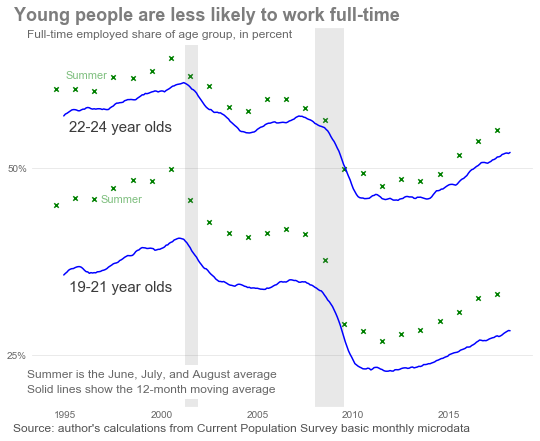

In [158]:
ax = data['y1_ma'].plot(figsize=(9, 7), color='blue')
ax = plt.scatter([data[data['y1_summer'] > 0].index], [data[data['y1_summer'] > 0]['y1_summer']], 
                 color='green', s=20, marker='x')

ax = data['y2_ma'].plot(color='blue')
ax = plt.scatter([data[data['y2_summer'] > 0].index], [data[data['y2_summer'] > 0]['y2_summer']], 
                 color='green', s=20, marker='x')
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.18)
    
plt.text('1995-03-01', 0.335, '19-21 year olds', size=15, alpha=0.9)
plt.text('1995-03-01', 0.55, '22-24 year olds', size=15, alpha=0.9)
plt.text('1996-11-01', 0.454, 'Summer', size=11, color='green', alpha=0.5)
plt.text('1995-01-01', 0.62, 'Summer', size=11, color='green', alpha=0.5)
plt.text('1993-01-01', 0.22, 'Summer is the June, July, and August average', fontsize=12, alpha=0.7, backgroundcolor='white')
plt.text('1993-01-01', 0.2, 'Solid lines show the 12-month moving average', fontsize=12, alpha=0.7, backgroundcolor='white')
plt.ylim(0.18, 0.69)
plt.title('Young people are less likely to work full-time', size=18, weight='bold', alpha=0.6, x=0.35)
plt.text('1993-01-01', 0.675, 'Full-time employed share of age group, in percent', size=12, alpha=0.7, backgroundcolor='white')

plt.xlabel("Source: author's calculations from Current Population Survey basic monthly microdata", 
           size=12, alpha=0.8, x=0.42)
plt.yticks([0.25, 0.5], ['25%', '50%'], size=10, alpha=0.7)
plt.xticks(['1995-01-01', '2000-01-01', '2005-01-01', '2010-01-01', '2015-01-01'], 
           ['1995', '2000', '2005', '2010', '2015'], size=10, alpha=0.7)
plt.grid(True, which='major', axis='y', alpha=0.5)
plt.savefig('fte_by_age.png', bbox_inches='tight', dpi=250)

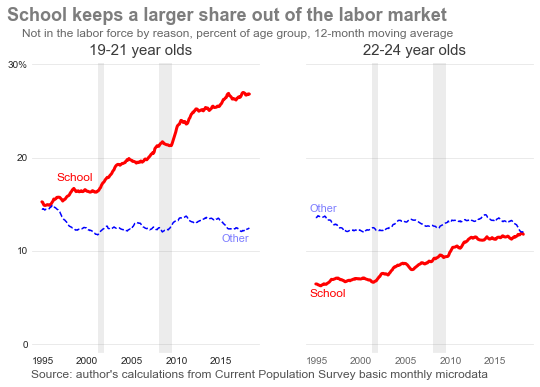

In [157]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
ax1.plot(data['n1'].rolling(12).mean(), color='red', linewidth=3)
ax1.plot(data['o1'].rolling(12).mean(), linestyle='dashed', color='blue')
ax1.grid(True, which='major', axis='y', alpha=0.5)
ax1.text('2000-03-01', 0.31, '19-21 year olds', size=15, alpha=0.9, backgroundcolor='white')
ax1.text('2015-01-01', 0.109, 'Other', size=11, color='blue', alpha=0.5)
ax1.text('1996-07-01', 0.175, 'School', size=12, color='red', alpha=1.0)
for i, v in rec_dt:
    ax1.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.15)


ax2.plot(data['n2'].rolling(12).mean(), color='red', linewidth=3)
ax2.plot(data['o2'].rolling(12).mean(), linestyle='dashed', color='blue')
ax2.grid(True, which='major', axis='y', alpha=0.5)
ax2.text('2000-03-01', 0.31, '22-24 year olds', size=15, alpha=0.9, backgroundcolor='white')
ax2.text('1994-03-01', 0.142, 'Other', size=11, color='blue', alpha=0.5)
ax2.text('1994-03-01', 0.05, 'School', size=12, color='red', alpha=1.0)
for i, v in rec_dt:
    ax2.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.15)

f.set_size_inches(9, 6)
plt.text('1962-01-01', 0.33, 'Not in the labor force by reason, percent of age group, 12-month moving average', 
         size=12, alpha=0.7, backgroundcolor='white')
plt.ylim(-0.01, 0.34)
plt.yticks([0.0, 0.1, 0.2, 0.3], ['0', '10', '20', '30%'], size=10, alpha=0.7)
plt.xticks(['1995-01-01', '2000-01-01', '2005-01-01', '2010-01-01', '2015-01-01'], 
           ['1995', '2000', '2005', '2010', '2015'], size=10, alpha=0.7)
plt.title('School keeps a larger share out of the labor market', 
          ha='right', size=18, weight='bold', alpha=0.6, x=0.62)
plt.xlabel("Source: author's calculations from Current Population Survey basic monthly microdata", ha='right', 
           size=12, alpha=0.8, x=0.8)
plt.savefig('nilf_by_age.png', bbox_inches='tight', dpi=250)